In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
from sklearn import datasets, model_selection, tree, metrics
from sklearn import decomposition as dc
from sklearn import ensemble as es
from sklearn import feature_selection as fs
from matplotlib import pyplot
from mlxtend import plotting
from sklearn import naive_bayes
from sklearn import neural_network
from sklearn import cluster, metrics
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.utils import shuffle
from sklearn.utils import resample

In [ ]:
pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
def interpol(df):
  df_interpol= df.head(1)
  df_interpol.reset_index(inplace=True, drop=True)
  df_interpol.drop(0, axis=0, inplace=True)
  for alpha in (0.25, 0.5, 0.75):
    for index in range(0,df.shape[0]-1):
      df_interpol.loc[index]= (df.iloc[index])*alpha+ (df.iloc[index+1])*(1-alpha)
  add_interpol = pd.concat([df, df_interpol], ignore_index=True, axis=0)
  return add_interpol

In [ ]:
def gaussian_mask(df, sigma):
  df_con = df.drop(['Poorly controled DM', 'bmi range', 'Pre op r/t','Gender',
        'ETE/ETS', 'Tumor site',
        'Free flap type', 'Recipiant', 'HTN', 'Smoke', 'Failure'], axis=1)
  df_cat = df[['Poorly controled DM', 'bmi range', 'Pre op r/t','Gender',
        'ETE/ETS', 'Tumor site',
        'Free flap type', 'Recipiant', 'HTN', 'Smoke', 'Failure']]
  mu, sigma = 0, sigma
  noise = pd.DataFrame(np.random.normal(mu, sigma, df_con.shape), index= df_con.index)
  noise.columns =df_con.columns
  df_con_gau = df_con+ noise
  df_new = pd.concat([df_con_gau,df_cat], axis=1)
  df_new = df_new[['bmi', 'bmi range','Poorly controled DM', 'Pre op r/t', 'Age',
       'Gender', 'Pre op hb', 'Post op day 1 hb', 'Delta hb','Delta hb%',
       'Total blood loss', 'Op time(min)', 'ETE/ETS',
       'Total ischemic time(hrs)', 'Tumor site', 'Free flap type', 'Recipiant',
       'Flap size', 'HTN', 'Smoke', 'Failure']]
  return df_new

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/論文投稿/AI for flap failure/meeting material/20231021.csv')

In [ ]:
scoredata = pd.DataFrame(columns=['sen','spe','AUROC'])
for i in range(50):
  score = []
  df2_failure = df2[df2['Failure']==1]
  df2_survived= df2[df2['Failure']==0]
  df2_survived = shuffle(df2_survived)
  df2_survived_train = df2_survived.head(467)
  df2_survived_test = df2_survived.tail(111)
  df2_failure = shuffle(df2_failure)
  df2_failure_train = df2_failure.head(53)
  df2_failure_test = df2_failure.tail(13)
  # print(df2_survived_test.index.isin(df2_survived_train.index))
  # print(df2_failure_test.index.isin(df2_failure_train.index))
  df2_failure_train = resample(df2_failure_train, replace=True, n_samples = math.ceil((df2_failure_train.shape[0])*6), random_state=123)
  df2_failure_train = interpol(df2_failure_train)
  df2_failure_train = gaussian_mask(df2_failure_train, 1)
  df_train = pd.concat([df2_failure_train, df2_survived_train], ignore_index= True, axis=0)
  df_test = pd.concat([df2_failure_test, df2_survived_test], ignore_index= True, axis=0)
  dx_train = df_train.pop('Failure')
  dx_test = df_test.pop('Failure')

  df_cat = ['Poorly controled DM', 'bmi range', 'Pre op r/t','Gender',
        'ETE/ETS', 'Tumor site',
        'Free flap type', 'Recipiant', 'HTN', 'Smoke']
  for i in df_cat:
    df_train[i] = df_train[i].apply(lambda ss: math.ceil(ss))
    df_test[i] = df_test[i].apply(lambda ss: math.ceil(ss))

  svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),
                    ('SVM',SVC(probability=True, C=10, gamma=0.001, kernel='rbf',random_state=42))])
  svm_clf = svm_pipeline.fit(df_train, dx_train)
  y_test_svm = svm_clf.predict(df_test)

  # logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),
  #                     ('LR',LogisticRegression(penalty='l2', random_state=42))])
  # lr_clf = logreg_pipeline.fit(df_train, dx_train)
  # y_test_lr = lr_clf.predict(df_test)

  # rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),
  #                   ('RF',es.RandomForestClassifier(bootstrap=True, max_features=3, n_estimators=64, random_state=42))])
  # rf_clf = rf_pipeline.fit(df_train, dx_train)
  # y_test_rf = rf_clf.predict(df_test)

  cm = confusion_matrix(dx_test, y_test_svm)
  sen = cm[1,1]/(cm[1,1]+cm[1,0])
  spe = cm[0,0]/(cm[0,1]+cm[0,0])
  micro_roc_auc_ovr_svm = roc_auc_score(dx_test, y_test_svm, multi_class="ovr", average="micro")
  score.append(sen)
  score.append(spe)
  score.append(micro_roc_auc_ovr_svm)
  scoredata = scoredata.append(pd.Series(score, index=scoredata.columns, name=i))

  # cm = confusion_matrix(dx_test, y_test_lr)
  # sen = cm[1,1]/(cm[1,1]+cm[1,0])
  # spe = cm[0,0]/(cm[0,1]+cm[0,0])
  # micro_roc_auc_ovr_lr = roc_auc_score(dx_test, y_test_lr, multi_class="ovr", average="micro")
  # score.append(sen)
  # score.append(spe)
  # score.append(micro_roc_auc_ovr_lr)
  # scoredata = scoredata.append(pd.Series(score, index=scoredata.columns, name=i))

  # cm = confusion_matrix(dx_test, y_test_rf)
  # sen = cm[1,1]/(cm[1,1]+cm[1,0])
  # spe = cm[0,0]/(cm[0,1]+cm[0,0])
  # micro_roc_auc_ovr_rf = roc_auc_score(dx_test, y_test_rf, multi_class="ovr", average="micro")
  # score.append(sen)
  # score.append(spe)
  # score.append(micro_roc_auc_ovr_rf)
  # scoredata = scoredata.append(pd.Series(score, index=scoredata.columns, name=i))

  # sen = cm[0,0]/(cm[0,0]+cm[1,0])
  # spe = cm[1,1]/(cm[0,1]+cm[1,1])

[0 1] [0 1]
[1 3 2 0 5 4] [2 1 0 3 4]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1 4 3 2] [1 0 4]
[0 1 2] [0 1 2]
[0 1] [0 1]
[0 1] [1 0]
[2 0 1] [0 2]
[0 1] [1 0]
[1 2 0 3 5 4] [2 1 3 0]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 4 3 1 2] [0 1 4]
[1 0 2] [0 1 2]
[0 1] [0 1]
[1 0] [0 1]
[0 2 1] [0 2 1]
[1 0] [0 1]
[1 0 2 5 3 4] [2 1 0 3 4]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 3 4 1 2] [0 1 4]
[0 1 2] [0 1 2]
[0 1] [0 1]
[0 1] [1 0]
[2 0 1] [0 2 1]
[0 1] [0 1]
[2 1 0 5 3 4] [1 2 3 0 4]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0]
[0 3 1 4 2] [0 1 4 2]
[1 0 2] [1 0 2]
[0 1] [0 1]
[0 1] [0 1]
[2 0 1] [0 2 1]
[0 1] [0 1]
[3 1 2 0 5 4] [1 2 0 3 4]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 3 1 4 2] [0 1 2 4]
[0 1 2] [1 0 2]
[0 1] [0 1]
[0 1] [0 1]
[0 2 1] [0 1 2]
[0 1] [0 1]
[2 1 3 0 4] [1 2 0 5 3 4]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[1 0 3 4 2] [1 0 4]
[0 1 2] [0 1]
[0 1] [0 1]
[0 1] [1 0]
[2 0 1] [2 0 1]
[0 1] [0 1]
[2 1 0 3 5 4] [1 0 2 3 4]
[0 1] [0 1]
[0 1] [0 1]
[0 1] [0 1]
[0 1 3 4 2] [0 4 1]
[0 1 2] [1

In [ ]:
print(df2_failure_train.shape)
scoredata = scoredata.sort_values(by='AUROC', ascending=False, axis=0)
print(scoredata['AUROC'].head(5).mean())
print(scoredata['AUROC'].head(5).std())
print(scoredata['sen'].head(5).mean())
print(scoredata['sen'].head(5).std())
print(scoredata['spe'].head(5).mean())
print(scoredata['spe'].head(5).std())
scoredata.head(10)

(635, 21)
0.6458073458073457
0.026966321290440066
0.7384615384615384
0.08770580193070292
0.5531531531531532
0.04707153325265992


,sen,spe,AUROC
Smoke,0.846154,0.522523,0.684338
Smoke,0.769231,0.549550,0.659390
Smoke,0.692308,0.585586,0.638947
Smoke,0.769231,0.495495,0.632363
Smoke,0.615385,0.612613,0.613999
Smoke,0.692308,0.531532,0.611920
Smoke,0.615385,0.603604,0.609494
Smoke,0.692308,0.513514,0.602911
Smoke,0.769231,0.432432,0.600832
Smoke,0.769231,0.432432,0.600832


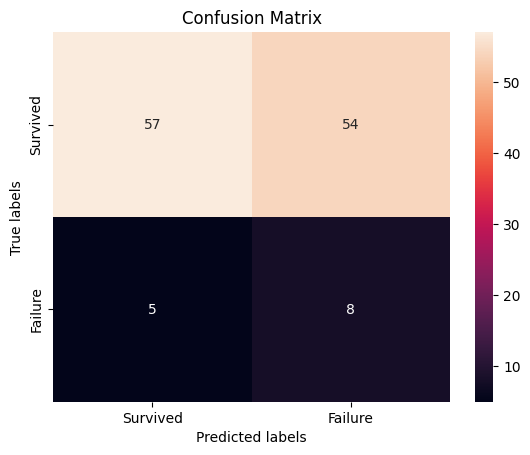

In [ ]:
ax= plt.subplot()
cm = confusion_matrix(dx_test, y_test_svm)
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Survived', 'Failure']); ax.yaxis.set_ticklabels(['Survived', 'Failure']);

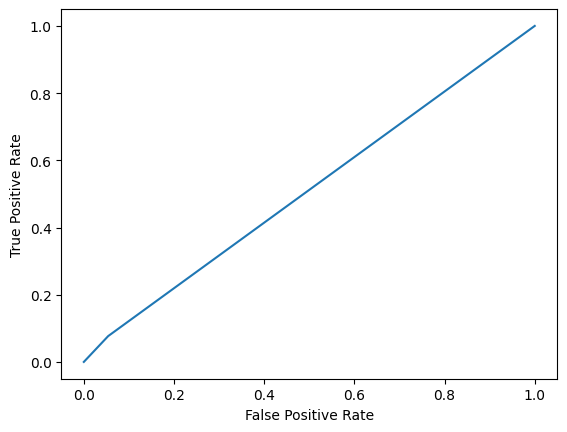

In [ ]:
fpr, tpr, _ = metrics.roc_curve(dx_test, y_test_rf)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

SVM

177+ 145
sen      0.576263
spe      0.608679
AUROC    0.583036

56+ 145
sen      0.621152
spe      0.589097
AUROC    0.579968



In [ ]:
# svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(probability=True, C=1000, gamma=0.0001, kernel='rbf',random_state=42))])
# rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',es.RandomForestClassifier(bootstrap=True, max_features=3, n_estimators=64, random_state=42))])
# logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(penalty='l2', random_state=42))])

# svm_clf = svm_pipeline.fit(df_train, dx_train)
# rf_clf = rf_pipeline.fit(df_train, dx_train)
# lr_clf = logreg_pipeline.fit(df_train, dx_train)

In [ ]:
y_test_svm = svm_clf.predict(df_test)
y_test_rf = rf_clf.predict(df_test)
y_test_lr = lr_clf.predict(df_test)

micro_roc_auc_ovr_svm = roc_auc_score(dx_test, y_test_svm, multi_class="ovr", average="micro")
micro_roc_auc_ovr_rf = roc_auc_score(dx_test, y_test_rf, multi_class="ovr", average="micro")
micro_roc_auc_ovr_lr = roc_auc_score(dx_test, y_test_lr, multi_class="ovr", average="micro")
print(micro_roc_auc_ovr_svm, micro_roc_auc_ovr_rf, micro_roc_auc_ovr_lr)

0.49099099099099097 0.49099099099099097 0.47990297990297986


In [ ]:
# ax= plt.subplot()
# cm = confusion_matrix(dx_test, y_test_svm)
# sns.heatmap(cm, annot=True, ax = ax)

# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
# ax.set_title('Confusion Matrix');
# ax.xaxis.set_ticklabels(['Survived', 'Negative']); ax.yaxis.set_ticklabels(['Positive', 'Negative']);

In [ ]:
# sen = cm[0,0]/(cm[0,0]+cm[1,0])
# spe = cm[1,1]/(cm[0,1]+cm[1,1])
# (sen, spe)

In [ ]:
# defining parameter range
svm_param_grid = {'C': [0.1, 1, 10, 100, 1000],
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'kernel': ['rbf']}

svm = SVC(random_state=42)

grid = GridSearchCV(svm,svm_param_grid)

In [ ]:
grid.fit(df_train,dx_train)

GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
# n_estimators =[64,100,128,200]
# max_features = [2,3,5,7]
# bootstrap = [True,False]

# param_grid = {'n_estimators':n_estimators,
#              'max_features':max_features,
#              'bootstrap':bootstrap}

In [ ]:
# rfc = es.RandomForestClassifier()

In [ ]:
#grid = GridSearchCV(rfc,param_grid)

#grid.fit(df_train,dx_train)

In [ ]:
# grid.best_params_

In [ ]:
# df2_failure_train_gau = df2_failure_train.copy()
# df2_failure_train_gau_con = df2_failure_train_gau.drop(['Poorly controled DM', 'bmi range', 'Pre op r/t','Gender',
#         'ETE/ETS', 'Tumor site',
#         'Free flap type', 'Recipiant', 'Failure'], axis=1)
# df2_failure_train_gau_cat = df2_failure_train_gau[['Poorly controled DM', 'bmi range', 'Pre op r/t','Gender',
#         'ETE/ETS', 'Tumor site',
#         'Free flap type', 'Recipiant', 'Failure']]
# df2_failure_train_gau_con.shape

In [ ]:
# mu, sigma = 0, 1
# # creating a noise with the same dimension as the dataset (2,2)
# noise = pd.DataFrame(np.random.normal(mu, sigma, [56,10]), index= df2_failure_train_gau_con.index)
# noise.columns =df2_failure_train_gau_con.columns

In [ ]:
# df2_failure_train_gau_con_withnoise = df2_failure_train_gau_con+noise
# df2_failure_train_gau = pd.concat([df2_failure_train_gau_con_withnoise, df2_failure_train_gau_cat], axis=1)
# df2_failure_train_gau = df2_failure_train_gau[['bmi', 'bmi range','Poorly controled DM', 'Pre op r/t', 'Age',
#        'Gender', 'Pre op hb', 'Post op day 1 hb', 'Delta hb','Delta hb%',
#        'Total blood loss', 'Op time(min)', 'ETE/ETS',
#        'Total ischemic time(hrs)', 'Tumor site', 'Free flap type', 'Recipiant',
#        'Flap size', 'Failure']]
# df2_failure_train_gau.shape

In [ ]:
# df_interpol= df2_failure_train.head(1)
# df_interpol.reset_index(inplace=True, drop=True)

In [ ]:
# df_interpol.drop(0, axis=0, inplace=True)
# for alpha in (0.25, 0.5, 0.75):
#   for index in range(0,55):
#     df_interpol.loc[index]= (df2_failure_train.iloc[index])*alpha+ (df2_failure_train.iloc[index+1])*(1-alpha)

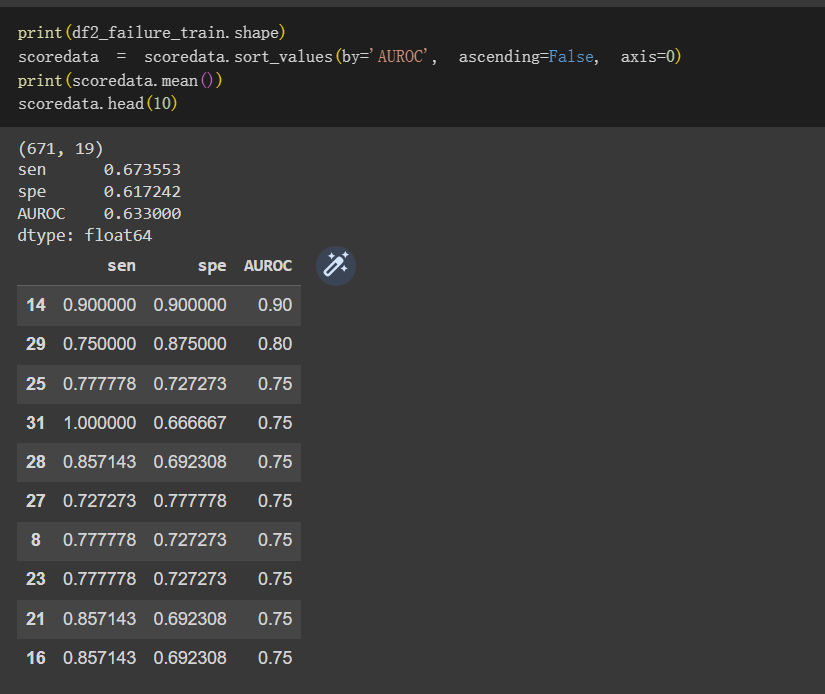

SVM 547/56x2x6

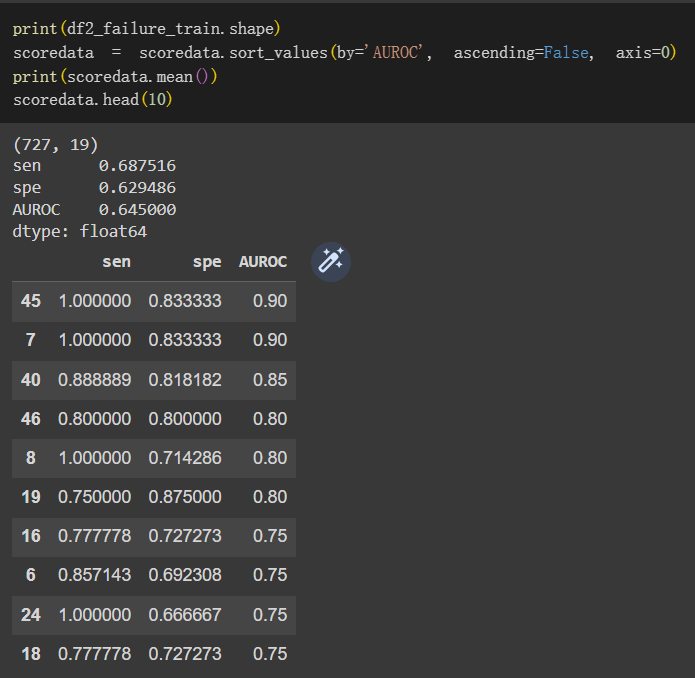

SVM 547/56x2x6.5

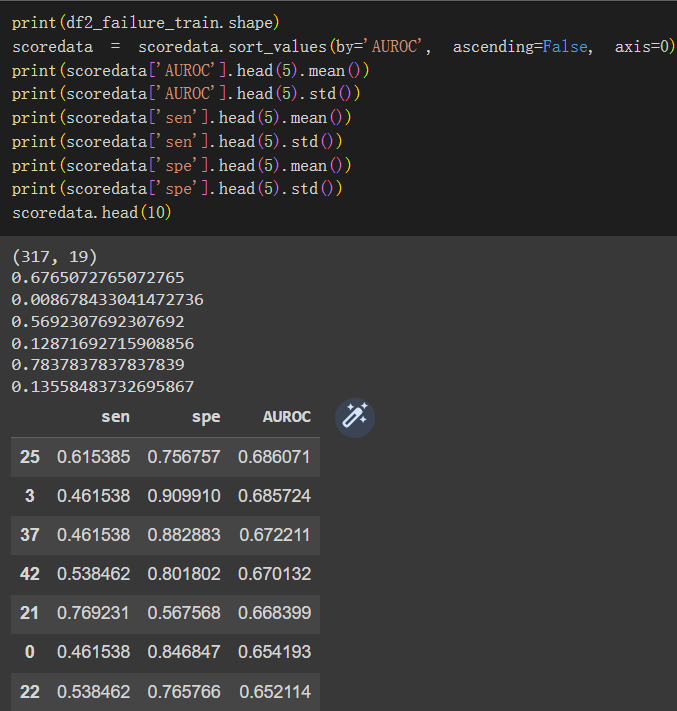
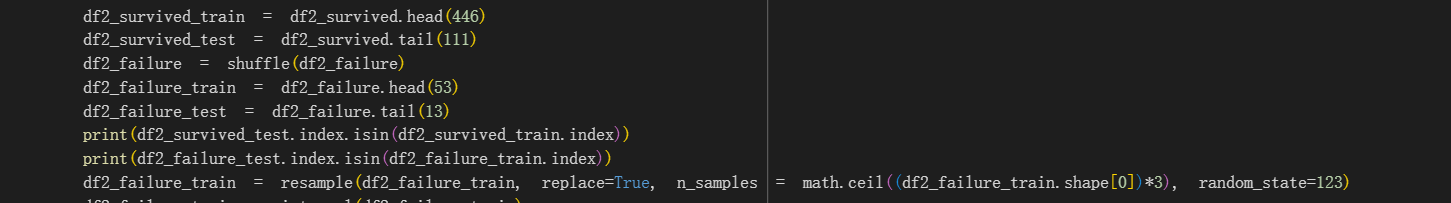

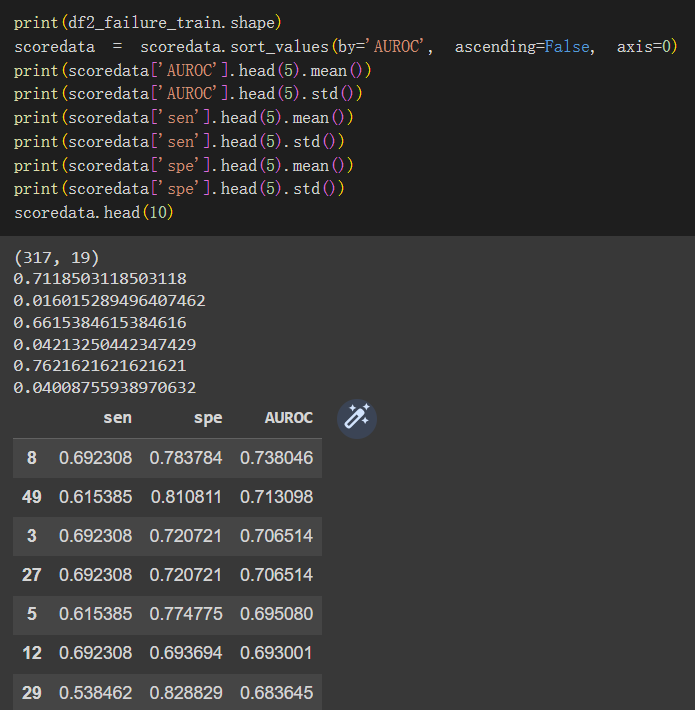

LR的

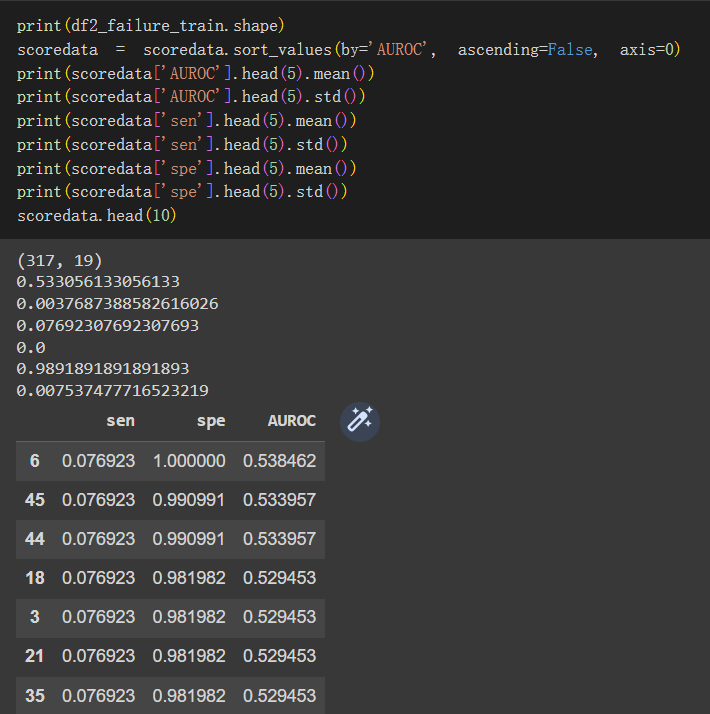

RF的

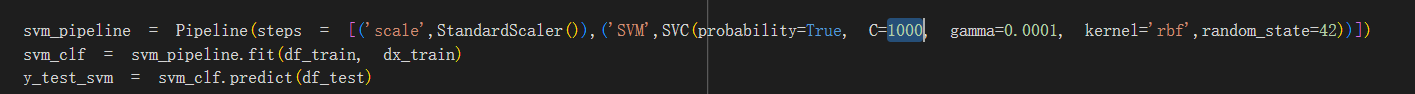

In [ ]:
df_train = pd.concat([df2_failure_train, df2_survived_train], ignore_index= True, axis=0)
df_test = pd.concat([df2_failure_test, df2_survived_test], ignore_index= True, axis=0)
dx_train = df_train.pop('Failure')
dx_test = df_test.pop('Failure')

In [ ]:
df_train_con1 = df_train.drop(['Total ischemic time(hrs)'], axis=1)
df_test_con1 = df_test.drop(['Total ischemic time(hrs)'], axis=1)
svm_clf1 = svm_pipeline.fit(df_train_con1, dx_train)
y_test1 = svm_clf.predict(df_test_con1)

In [ ]:
df_train_con12 = df_train.drop(['bmi', 'Age'], axis=1)
df_test_con12 = df_test.drop(['bmi', 'Age'], axis=1)
svm_clf12 = svm_pipeline.fit(df_train_con12, dx_train)
y_test12 = svm_clf.predict(df_test_con12)

In [ ]:
df_train_con128 = df_train.drop(['bmi', 'Age', 'Total ischemic time(hrs)'], axis=1)
df_test_con128 = df_test.drop(['bmi', 'Age', 'Total ischemic time(hrs)'], axis=1)
svm_clf128 = svm_pipeline.fit(df_train_con128, dx_train)
y_test128 = svm_clf.predict(df_test_con128)

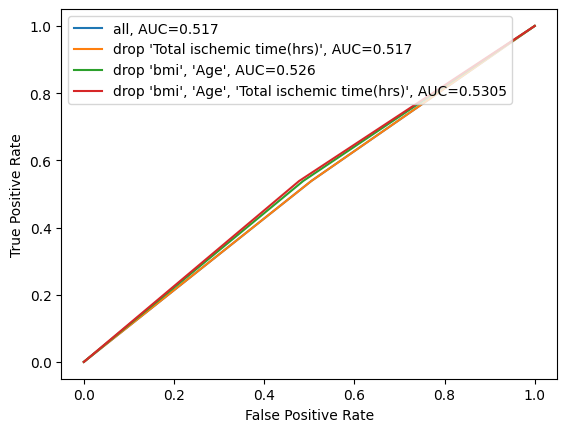

In [ ]:
fpr, tpr, _ = metrics.roc_curve(dx_test, y_test_svm)
auc = round(metrics.roc_auc_score(dx_test, y_test_svm), 4)

fpr1, tpr1, _ = metrics.roc_curve(dx_test, y_test1)
auc1 = round(metrics.roc_auc_score(dx_test, y_test1), 4)

fpr2, tpr2, _ = metrics.roc_curve(dx_test, y_test12)
auc2 = round(metrics.roc_auc_score(dx_test, y_test12), 4)

fpr3, tpr3, _ = metrics.roc_curve(dx_test, y_test128)
auc3 = round(metrics.roc_auc_score(dx_test, y_test128), 4)

#create ROC curve
plt.plot(fpr,tpr, label="all, AUC="+str(auc))
plt.plot(fpr1,tpr1, label="drop 'Total ischemic time(hrs)', AUC="+str(auc1))
plt.plot(fpr2,tpr2, label="drop 'bmi', 'Age', AUC="+str(auc2))
plt.plot(fpr3,tpr3, label="drop 'bmi', 'Age', 'Total ischemic time(hrs)', AUC="+str(auc3))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()